In [1]:
from IPython.core.interactiveshell import InteractiveShell
import time

old_run_cell = InteractiveShell.run_cell

def timing_run_cell(self, raw_cell, *args, **kwargs):
    t0 = time.time()
    result = old_run_cell(self, raw_cell, *args, **kwargs)
    t1 = time.time()
    print(f"Execution time: {t1 - t0:.1f} seconds")
    return result

InteractiveShell.run_cell = timing_run_cell

In [2]:
# !pip install zoobot
# !pip install pyro-ppl
# !pip install pytorch_lightning
# !pip install timm

Execution time: 0.0 seconds


In [3]:
import sys
sys.path.append('../Scripts')

import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from astropy.io import fits
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from zoobot.pytorch.training import finetune
from zoobot.pytorch.training.finetune import FinetuneableZoobotClassifier, LinearHead
from torchvision.models import efficientnet_b0

from auxiliary_functions import (aggressive_arcsinh_scaling, ClassificationDataset_values, 
                        train_epoch, multilabel_train_epoch, evaluate, multilabel_evaluate, compute_metrics, evaluate_with_probabilities, 
                        multilabel_evaluate_with_probabilities, plot_confusion_matrix, multilabel_plot_confusion_matrix, FocalLossBCE)
from DataCore import ClassificationDataset_labels, ClassificationArrayDataset


Execution time: 9.7 seconds


In [4]:
unityTransform = lambda x: x

# Load labels and data
label_file = "/net/virgo01/data/users/spirov/Deep/catalog_tng100_jwst_all_50sns.fits"
labels = fits.open(label_file)[1]  # second HDU

datadir = "/net/virgo01/data/users/mahesh/DeepLearning/data/"

# Create the dataset using the scaling
dataset = ClassificationArrayDataset(datadir, labels, aggressive_arcsinh_scaling)

# dataset splits - you gotta stratify to make sure that all the datasets have galaxies with all labels, otherwise you end up with no pre/post mergers in val or test splits
# all_multilabels = []
# for i in range(len(dataset)):
#     _, label = dataset[i]
#     all_multilabels.append(label.item())
# all_multilabels = np.array(all_multilabels)

# Gather multi-label data from your dataset
all_multilabels = []
for i in range(len(dataset)):
    _, label_tensor = dataset[i]  # label_tensor is shape [2]
    arr = label_tensor.numpy().astype(int)  # e.g. [0,1], [1,1], etc.
    # Convert [a,b] -> single int in [0..3]
    single_class = arr[0]*2 + arr[1]  # e.g. [1,0] => 2*1 + 0 = 2
    all_multilabels.append(single_class)

all_multilabels = np.array(all_multilabels)

# First split: 90% train+val, 10% test
trainval_indices, test_indices = train_test_split(
    np.arange(len(dataset)),
    test_size=0.1,
    stratify=all_multilabels,
    random_state=42
)

# Second split: of the 90%, 90% train, 10% val (so total 81/9/10)
trainval_labels = all_multilabels[trainval_indices]
train_indices, val_indices = train_test_split(
    trainval_indices,
    test_size=0.1,
    stratify=trainval_labels,
    random_state=42
)

# label2idx = {0: [], 1: [], 2: [], 3: []}

# for i in range(len(dataset)):
#     _, label_tensor = dataset[i]         # shape [2], e.g. [0,1]
#     arr = label_tensor.numpy().astype(int)
#     combo = arr[0]*2 + arr[1]           # [a,b] -> integer in [0..3]
#     label2idx[combo].append(i)

# train_indices, val_indices, test_indices = [], [], []
# for combo, idxs in label2idx.items():
#     np.random.shuffle(idxs)
#     n = len(idxs)
#     n_test = int(0.10 * n)
#     n_val  = int(0.09 * n)

#     test_indices.extend(idxs[:n_test])
#     val_indices.extend(idxs[n_test:n_test + n_val])
#     train_indices.extend(idxs[n_test + n_val:])

# np.random.shuffle(train_indices)
# np.random.shuffle(val_indices)
# np.random.shuffle(test_indices)

train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# train_counts = [0, 0, 0]
# for i in train_indices:
#     row = labels.data[i]
#     if row['is_pre_merger'] == 1: 
#         train_counts[1] += 1
#     elif row['is_ongoing_merger'] == 1 or row['is_post_merger'] == 1: 
#         train_counts[2] += 1
#     else: 
#         train_counts[0] += 1
# weights = 1.0 / np.array(train_counts)
# weights /= weights.sum()
# weights_t = torch.tensor(weights, dtype=torch.float)

pos_count = [0,0]
neg_count = [0,0]

for i in train_indices:
    _, label_tensor = dataset[i]
    arr = label_tensor.numpy().astype(int)  # shape [2]
    for dim in [0,1]:
        if arr[dim] == 1:
            pos_count[dim] += 1
        else:
            neg_count[dim] += 1

pos_weight_vals = []
for dim in [0,1]:
    # If no positives for that dim, skip or set pos_weight=1.0 to avoid zero-div
    if pos_count[dim] == 0:
        pos_weight_vals.append(1.0)
    else:
        pw = neg_count[dim] / float(pos_count[dim])
        pos_weight_vals.append(pw)

# Model Setup with Zoobot (One-Stage Classification)
# load the Zoobot pre-trained EfficientNet-B0 model
model = FinetuneableZoobotClassifier(
    name='hf_hub:mwalmsley/zoobot-encoder-efficientnet_b0',
    n_blocks=0,              # number of layers to train - max 7 for efficientnet_b0, set 0 for only head
    learning_rate=1e-5,      # Use their learning rate
    lr_decay=0.5,
    num_classes=2            # Three classes: non-merger, pre-merger, post-merger
)
# uncomment below to use torchvision's EfficientNet-B0 (note: this model is pre-trained on ImageNet, not on Galaxy Zoo labels)
#model = efficientnet_b0(pretrained=True)

# Modify the classifier head to output three classes
if hasattr(model, 'head'):
    in_features = model.head.linear.in_features
    # Update the dropout probability (optional
    model.head.dropout.p = 0.2
    
    model.head.linear = nn.Linear(in_features, 2)
else:
    raise ValueError("Model structure not recognized. Please adjust or face my wrath.")

# Use GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

Execution time: 1858.0 seconds


In [5]:
#model.head

Execution time: 0.0 seconds


In [6]:
with fits.open(label_file) as hdul:
    data = hdul[1].data  # The second HDU

n_total = len(data)

# Count how many are flagged as each type
n_pre = len(data[data['is_pre_merger'] == 1])
n_ongoing = len(data[data['is_ongoing_merger'] == 1])
n_post = len(data[data['is_post_merger'] == 1])

# A simple definition of 'non-merger' is galaxies that have none of the three flags
n_non = n_total - (n_pre + n_ongoing + n_post)

print(f"Total galaxies: {n_total}")
print(f"Pre-merger: {n_pre} ({n_pre / n_total * 100:.2f}%)")
print(f"Ongoing merger: {n_ongoing} ({n_ongoing / n_total * 100:.2f}%)")
print(f"Post-merger: {n_post} ({n_post / n_total * 100:.2f}%)")
print(f"Non-merger: {n_non} ({n_non / n_total * 100:.2f}%)")

Total galaxies: 58436
Pre-merger: 1267 (2.17%)
Ongoing merger: 511 (0.87%)
Post-merger: 636 (1.09%)
Non-merger: 56022 (95.87%)
Execution time: 0.0 seconds


Total galaxies: 58436

Pre-merger: 1267 (2.17%)

Ongoing merger: 511 (0.87%)

Post-merger: 636 (1.09%)

Non-merger: 56022 (95.87%)

In [7]:
n_00 = 0  # neither pre nor post
n_10 = 0  # pre only
n_01 = 0  # post only
n_11 = 0  # pre + post

for row in data:
    is_pre = (row['is_pre_merger'] == 1)
    is_ongoing = (row['is_ongoing_merger'] == 1)
    is_post = (row['is_post_merger'] == 1)
    
    bit0 = 1 if is_pre else 0
    bit1 = 1 if (is_ongoing or is_post) else 0
    
    if bit0 == 0 and bit1 == 0:
        n_00 += 1
    elif bit0 == 1 and bit1 == 0:
        n_10 += 1
    elif bit0 == 0 and bit1 == 1:
        n_01 += 1
    else:
        n_11 += 1

print(f"Total galaxies: {n_total}")
print(f"00 (no pre, no post): {n_00} ({n_00/n_total*100:.2f}%)")
print(f"10 (pre only):       {n_10} ({n_10/n_total*100:.2f}%)")
print(f"01 (post only):      {n_01} ({n_01/n_total*100:.2f}%)")
print(f"11 (pre + post):     {n_11} ({n_11/n_total*100:.2f}%)")

Total galaxies: 58436
00 (no pre, no post): 56053 (95.92%)
10 (pre only):       1236 (2.12%)
01 (post only):      1116 (1.91%)
11 (pre + post):     31 (0.05%)
Execution time: 2.1 seconds


In [8]:
checking = []
for i in test_indices:
    row = labels.data[i]
    if row['is_pre_merger'] == 1:
        checking.append(1)
    elif row['is_ongoing_merger'] == 1 or row['is_post_merger'] == 1:
        checking.append(2)
    else:
        checking.append(0)

unique, counts = np.unique(checking, return_counts=True)
print(dict(zip(unique, counts)))

{0: 5606, 1: 127, 2: 111}
Execution time: 0.2 seconds


In [9]:
# Hyperparameters (following the paper's one-stage configuration)
optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=0.005)
pos_weight = torch.tensor(pos_weight_vals, dtype=torch.float)
criterion = FocalLossBCE(gamma=2.0, alpha=1.0, pos_weight=pos_weight.to(device))#nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))
#criterion = nn.CrossEntropyLoss(weight=weights_t.to(device))

# training and validation Loop

num_epochs = 5
best_val_loss = np.inf
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

for epoch in range(num_epochs):
    last_print_time = time.time()
    train_loss, train_acc = multilabel_train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, val_preds, val_labels = multilabel_evaluate(model, val_loader, criterion, device)
    current_time = time.time()
    elapsed = current_time - last_print_time
    print(f"\n[{elapsed:.1f}s elapsed] Epoch {epoch+1}/{num_epochs}: "
          f"Train Loss = {train_loss:.3f}, Train Acc = {train_acc:.3f}; "
          f"Val Loss = {val_loss:.3f}, Val Acc = {val_acc:.3f}")

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    # Save the best model based on validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pth")


[234.0s elapsed] Epoch 1/5: Train Loss = 0.338, Train Acc = 0.089; Val Loss = 0.336, Val Acc = 0.183

[245.2s elapsed] Epoch 2/5: Train Loss = 0.335, Train Acc = 0.276; Val Loss = 0.333, Val Acc = 0.416

[221.7s elapsed] Epoch 3/5: Train Loss = 0.333, Train Acc = 0.434; Val Loss = 0.330, Val Acc = 0.492

[236.2s elapsed] Epoch 4/5: Train Loss = 0.331, Train Acc = 0.491; Val Loss = 0.327, Val Acc = 0.504

[235.7s elapsed] Epoch 5/5: Train Loss = 0.329, Train Acc = 0.496; Val Loss = 0.325, Val Acc = 0.517
Execution time: 1173.2 seconds



Test Loss: 0.328
Test Accuracy: 0.526


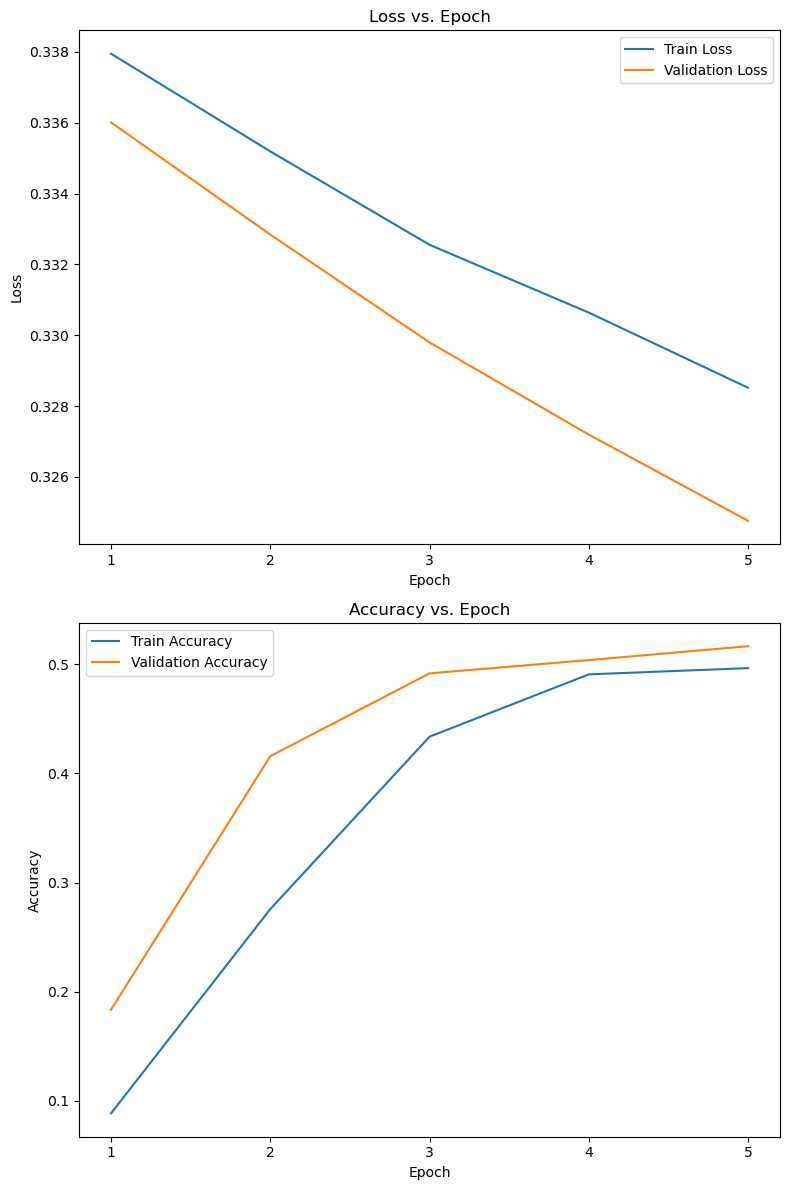

<Figure size 600x500 with 0 Axes>

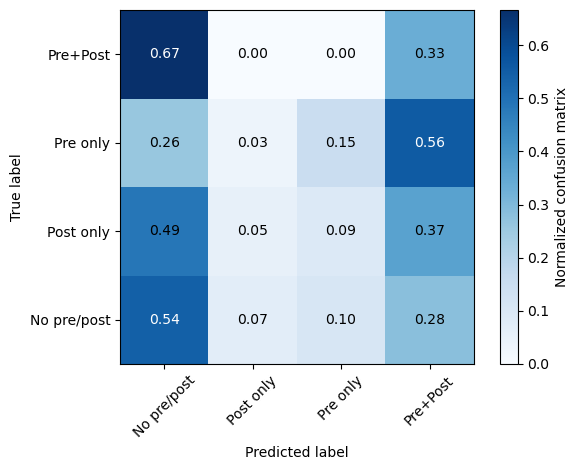

/tmp/ipykernel_2863354/451424771.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


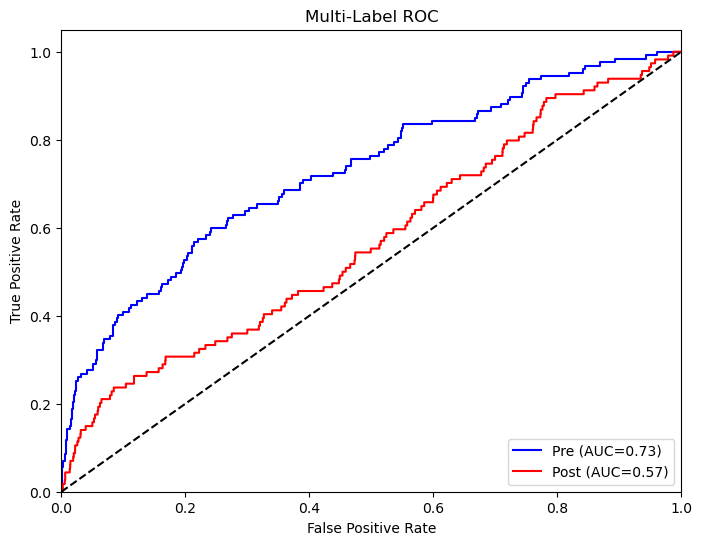

Execution time: 54.1 seconds


In [10]:
# Evaluation on Test Set
test_loss, test_acc, test_preds, test_labels = multilabel_evaluate(model, test_loader, criterion, device)
print(f"\nTest Loss: {test_loss:.3f}")
print(f"Test Accuracy: {test_acc:.3f}")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 12))

ax1.plot(range(1, num_epochs+1), train_losses, label="Train Loss")
ax1.plot(range(1, num_epochs+1), val_losses, label="Validation Loss")
ax1.set_xticks(range(1, num_epochs+1))
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.set_title("Loss vs. Epoch")
ax1.legend()

ax2.plot(range(1, num_epochs+1), train_accuracies, label="Train Accuracy")
ax2.plot(range(1, num_epochs+1), val_accuracies, label="Validation Accuracy")
ax2.set_xticks(range(1, num_epochs+1))
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.set_title("Accuracy vs. Epoch")
ax2.legend()

plt.tight_layout()
plt.show()

#confusion matrix
test_labels_arr, test_preds_arr = np.array(test_labels), np.array(test_preds)

plt.figure(figsize=(6,5))
multilabel_plot_confusion_matrix(
    y_true=test_labels_arr,
    y_pred=test_preds_arr,
    classes=["No pre/post","Post only","Pre only","Pre+Post"],#['Non-merger', 'Pre-merger', 'Post-merger'],#
    normalize=True
)

# Compute probabilities on the test set
model.load_state_dict(torch.load("best_model.pth"))
test_probs, test_labels = multilabel_evaluate_with_probabilities(model, test_loader, device)
test_preds = np.argmax(test_probs, axis=1)

# ROC Curves for Multi-class (One-vs-Rest)
# n_classes = 3
# # Binarize the true labels
# test_labels_bin = label_binarize(test_labels, classes=[0, 1, 2])
# fpr, tpr, roc_auc = {}, {}, {}

# for i in range(n_classes):
#     fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:,i], test_probs[:,i])
#     roc_auc[i] = auc(fpr[i], tpr[i])

# # Plot ROC curves for each class
# plt.figure(figsize=(8,6))
# colors = ['blue','red','green']
# for i,c in zip(range(n_classes),colors):
#     plt.plot(fpr[i], tpr[i], color=c, label=f'Class {i} (AUC={roc_auc[i]:.2f})')
# plt.plot([0,1],[0,1],'k--')
# plt.xlim([0,1]); plt.ylim([0,1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Multi-class ROC Curves')
# plt.legend(loc="lower right")
# plt.show()

fpr, tpr, roc_auc = {}, {}, {}

for i, name in enumerate(["Pre-merger", "Post-merger"]):
    fpr[i], tpr[i], _ = roc_curve(test_labels[:, i], test_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8,6))
colors = ["blue", "red"]
for i, color in enumerate(colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label=f"{['Pre','Post'][i]} (AUC={roc_auc[i]:.2f})")
plt.plot([0,1],[0,1],"k--")
plt.xlim([0,1]); plt.ylim([0,1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-Label ROC")
plt.legend(loc="lower right")
plt.show()

In [11]:
unique, counts = np.unique(test_preds_arr, return_counts=True)
print(dict(zip(unique, counts)))

{0.0: 7284, 1.0: 4404}
Execution time: 0.0 seconds
